In [42]:
import sqlite3
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import tree, metrics, model_selection, preprocessing
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
import pickle


In [43]:
cnx = sqlite3.connect('database1.sqlite')
dd = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", cnx)
print(dd)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


In [44]:
df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)

In [45]:
df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [46]:
    target = df.pop('overall_rating')

In [47]:
target.head()

0    67.0
1    67.0
2    62.0
3    61.0
4    61.0
Name: overall_rating, dtype: float64

In [48]:
target.isnull().values.sum()

836

In [49]:
target.describe()

count    183142.000000
mean         68.600015
std           7.041139
min          33.000000
25%          64.000000
50%          69.000000
75%          73.000000
max          94.000000
Name: overall_rating, dtype: float64

In [50]:
y = target.fillna(target.mean())
y.isnull().values.any()

False

In [51]:
df.columns

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

In [52]:
for col in df.columns:
    unique_cat = len(df[col].unique())
    print("{col}--> {unique_cat}..{typ}".format(col=col, unique_cat=unique_cat, typ=df[col].dtype))

id--> 183978..int64
player_fifa_api_id--> 11062..int64
player_api_id--> 11060..int64
date--> 197..object
potential--> 57..float64
preferred_foot--> 3..object
attacking_work_rate--> 9..object
defensive_work_rate--> 20..object
crossing--> 96..float64
finishing--> 98..float64
heading_accuracy--> 97..float64
short_passing--> 96..float64
volleys--> 94..float64
dribbling--> 98..float64
curve--> 93..float64
free_kick_accuracy--> 98..float64
long_passing--> 96..float64
ball_control--> 94..float64
acceleration--> 87..float64
sprint_speed--> 86..float64
agility--> 82..float64
reactions--> 79..float64
balance--> 82..float64
shot_power--> 97..float64
jumping--> 80..float64
stamina--> 85..float64
strength--> 83..float64
long_shots--> 97..float64
aggression--> 92..float64
interceptions--> 97..float64
positioning--> 96..float64
vision--> 98..float64
penalties--> 95..float64
marking--> 96..float64
standing_tackle--> 96..float64
sliding_tackle--> 95..float64
gk_diving--> 94..float64
gk_handling--> 91..

In [53]:
dummy_df = pd.get_dummies(df, columns=['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'])
dummy_df.head()

,id,player_fifa_api_id,player_api_id,date,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,defensive_work_rate_9,defensive_work_rate__0,defensive_work_rate_ean,defensive_work_rate_es,defensive_work_rate_high,defensive_work_rate_low,defensive_work_rate_medium,defensive_work_rate_o,defensive_work_rate_ormal,defensive_work_rate_tocky
0,1,218353,505942,2016-02-18 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
1,2,218353,505942,2015-11-19 00:00:00,71.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
2,3,218353,505942,2015-09-21 00:00:00,66.0,49.0,44.0,71.0,61.0,44.0,...,0,0,0,0,0,0,1,0,0,0
3,4,218353,505942,2015-03-20 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0
4,5,218353,505942,2007-02-22 00:00:00,65.0,48.0,43.0,70.0,60.0,43.0,...,0,0,0,0,0,0,1,0,0,0


In [54]:
X = dummy_df.drop(['id', 'date'], axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

In [56]:
imput = Imputer()
X_train = imput.fit_transform(X_train)
X_test = imput.fit_transform(X_test)

In [57]:
pipe = make_pipeline(StandardScaler(),             #preprocessing(standard scalling)
                     LinearRegression())           #estimator(linear regression)

cv = ShuffleSplit(random_state=0)   #defining type of cross_validation(shuffle spliting)

param_grid = {'linearregression__n_jobs': [-1]}     #parameters for model tunning

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)

In [58]:
grid.fit(X_train, y_train)    

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'linearregression__n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:

lin_reg = pickle.dumps(grid)

<IPython.core.display.Javascript object>


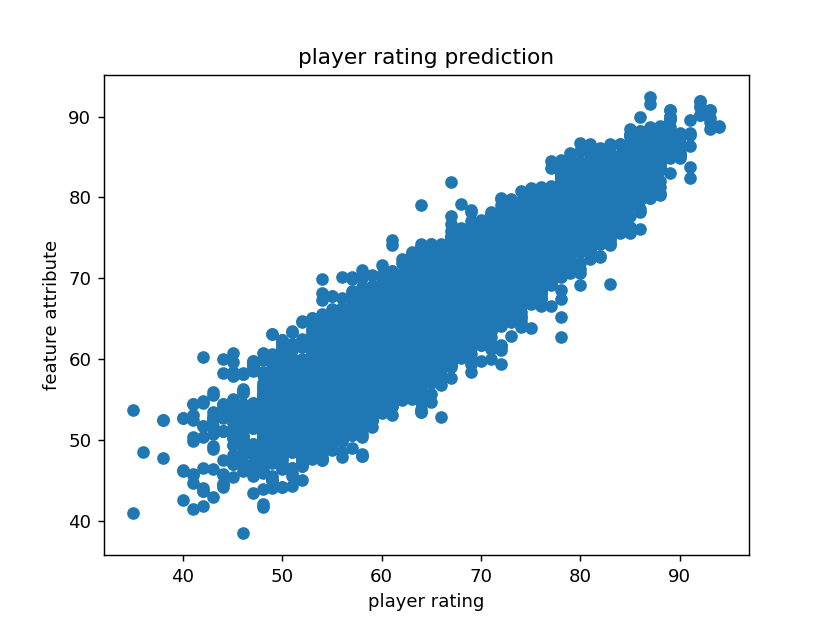

Text(0.5,1,'player rating prediction')

In [71]:
Y_pred = grid.predict(X_test)
# Visualising the Training set results
plt.scatter(y_test, Y_pred)
plt.xlabel("player rating")
plt.ylabel("feature attribute")
plt.title("player rating prediction")

In [39]:
pipe = make_pipeline(StandardScaler(),                  #preprocessing
                     DecisionTreeRegressor(criterion='mse', random_state=0))          #estimator

cv = ShuffleSplit(n_splits=10, random_state=42)        #cross validation

param_grid = {'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)          #training

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('decisiontreeregressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:

y_pred = grid.predict(X_test)

In [79]:
from matplotlib.colors import ListedColormap


def plot_decision(X, y, classifier, test_idx=None, resolution=0.02, figsize=(8,8)):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('#cc0000', '#003399', '#00cc00', '#999999', '#66ffff')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # get dimensions
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    xmin = xx1.min()
    xmax = xx1.max()
    ymin = xx2.min()
    ymax = xx2.max()
    
    # create the figure
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # plot the decision surface
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap, zorder=1)
    
    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                   y=X[y == cl, 1],
                   alpha=0.6, 
                   c=cmap(idx),
                   edgecolor='black',
                   marker='o',#markers[idx],
                   s=50,
                   label=cl,
                   zorder=3)

    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        ax.scatter(X_test[:, 0],
                   X_test[:, 1],
                   c='w',
                   alpha=1.0,
                   edgecolor='black',
                   linewidths=1,
                   marker='o',
                   s=150, 
                   label='test set',
                   zorder=2)

In [80]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision(X=X_combined, y=y_combined, classifier=dtree)
plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')
plt.show()

MemoryError: 